Part-2 Train a Generative model:
This notebook contains code to train the generative model(VAE with LSTM) on the dance sequences of length 64 and give an output of 64 lenght output sequence. And the results have been visualized by the previous task of part-1 (visualizing the data).

In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn as nn

Point Labels and Skeleton lines to make lines between joints for plotting

In [2]:
point_labels = ['ARIEL','C7','CLAV','LANK','LBHD','LBSH','LBWT','LELB','LFHD','LFRM','LFSH','LFWT','LHEL','LIEL','LIHAND','LIWR','LKNE','LKNI','LMT1','LMT5','LOHAND','LOWR','LSHN','LTHI','LTOE','LUPA','MBWT','MFWT','RANK','RBHD','RBSH','RBWT','RELB','RFHD','RFRM','RFSH','RFWT','RHEL','RIEL','RIHAND','RIWR','RKNE','RKNI','RMT1','RMT5','ROHAND','ROWR','RSHN','RTHI','RTOE','RUPA','STRN','T10']

skeleton_lines = [
#     ( (start group), (end group) ),
    (('LHEL',), ('LTOE',)), # toe to heel
    (('RHEL',), ('RTOE',)),
    (('LMT1',), ('LMT5',)), # horizontal line across foot
    (('RMT1',), ('RMT5',)),
    (('LHEL',), ('LMT1',)), # heel to sides of feet
    (('LHEL',), ('LMT5',)),
    (('RHEL',), ('RMT1',)),
    (('RHEL',), ('RMT5',)),
    (('LTOE',), ('LMT1',)), # toe to sides of feet
    (('LTOE',), ('LMT5',)),
    (('RTOE',), ('RMT1',)),
    (('RTOE',), ('RMT5',)),
    (('LKNE',), ('LHEL',)), # heel to knee
    (('RKNE',), ('RHEL',)),
    (('LFWT',), ('RBWT',)), # connect pelvis
    (('RFWT',), ('LBWT',)),
    (('LFWT',), ('RFWT',)),
    (('LBWT',), ('RBWT',)),
    (('LFWT',), ('LBWT',)),
    (('RFWT',), ('RBWT',)),
    (('LFWT',), ('LTHI',)), # pelvis to thighs
    (('RFWT',), ('RTHI',)),
    (('LBWT',), ('LTHI',)),
    (('RBWT',), ('RTHI',)),
    (('LKNE',), ('LTHI',)),
    (('RKNE',), ('RTHI',)),
    (('CLAV',), ('LFSH',)), # clavicle to shoulders
    (('CLAV',), ('RFSH',)),
    (('STRN',), ('LFSH',)), # sternum & T10 (back sternum) to shoulders
    (('STRN',), ('RFSH',)),
    (('T10',), ('LFSH',)),
    (('T10',), ('RFSH',)),
    (('C7',), ('LBSH',)), # back clavicle to back shoulders
    (('C7',), ('RBSH',)),
    (('LFSH',), ('LBSH',)), # front shoulders to back shoulders
    (('RFSH',), ('RBSH',)),
    (('LFSH',), ('RBSH',)),
    (('RFSH',), ('LBSH',)),
    (('LFSH',), ('LUPA',),), # shoulders to upper arms
    (('RFSH',), ('RUPA',),),
    (('LBSH',), ('LUPA',),),
    (('RBSH',), ('RUPA',),),
    (('LIWR',), ('LIHAND',),), # wrist to hand
    (('RIWR',), ('RIHAND',),),
    (('LOWR',), ('LOHAND',),),
    (('ROWR',), ('ROHAND',),),
    (('LIWR',), ('LOWR',),), # across the wrist
    (('RIWR',), ('ROWR',),),
    (('LIHAND',), ('LOHAND',),), # across the palm
    (('RIHAND',), ('ROHAND',),),
    (('LFHD',), ('LBHD',)), # draw lines around circumference of the head
    (('LBHD',), ('RBHD',)),
    (('RBHD',), ('RFHD',)),
    (('RFHD',), ('LFHD',)),
    (('LFHD',), ('ARIEL',)), # connect circumference points to top of head
    (('LBHD',), ('ARIEL',)),
    (('RBHD',), ('ARIEL',)),
    (('RFHD',), ('ARIEL',)),
]


Loading the dataset from the .np files using a custom Dataset object in PyTorch.

In [3]:
class DanceDataset(Dataset):
        def __init__(self, root_dir, transform=None, exclude_points=[26, 53]):
            self.root_dir = root_dir
            self.transform = transform
            self.exclude_points = exclude_points
            self.files = os.listdir(root_dir)
            self.files = [f for f in self.files if f.endswith('.npy')]
            self.files = sorted(self.files)
            # No need to initialize self.labels here as we'll use the file names directly
    
        def __len__(self):
            return len(self.files)
    
        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()
            file_name = self.files[idx]  # Get the file name
            file_path = os.path.join(self.root_dir, file_name)
            data = np.load(file_path)
    
            # Exclude specified points
            data = np.delete(data, self.exclude_points, axis=0)
    
            # Use the file name as the label (excluding the .npy extension)
            label = file_name[:-4]  # Remove the last 4 characters, which are ".npy"
    
            sample = {'data': data, 'label': label}
    
            if self.transform:
                sample = self.transform(sample)
    
            return sample

In [4]:
dataset = DanceDataset(root_dir='data')
print(len(dataset))


6


In [5]:
print(dataset[0]['label'])

mariel_betternot_and_retrograde


Sequence function to generate the sequences of length 64 from the dataset.

In [6]:
def create_seq(seq_length, data):
    sequences = []
    data = data.transpose(1, 0, 2)
    for j in range(len(data) - seq_length):
        sequences.append(data[j:j+seq_length])
    return sequences

Custom Dataset object to load the input and target sequences

In [7]:
from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, seq):
        self.seq = seq

    def __len__(self):
        # Subtract 1 so we always have a next sequence
        return len(self.seq) - 1

    def __getitem__(self, idx):
        current_seq = self.seq[idx]
        next_seq = self.seq[idx + 1]
        return current_seq, next_seq

we define our Variational Autoencoder (VAE) model. The VAE model is a type of generative model that learns to encode input data into a lower-dimensional latent space and then decode it back to the original space. The key feature of VAEs is that they impose a probabilistic structure on the latent space, typically assuming that the latent variables follow a Gaussian distribution.

The VAE model consists of two main parts:

1. **Encoder (Recognition model)**: The encoder takes the input data and encodes it into a latent space. The encoder is typically a neural network that outputs the parameters of the assumed Gaussian distribution in the latent space. These parameters are the mean and the standard deviation (or log-variance) of the Gaussian distribution.

2. **Decoder (Generative model)**: The decoder takes a point in the latent space and decodes it back into the original input space. The decoder is also typically a neural network. The input to the decoder is a sample from the Gaussian distribution defined by the encoder's outputs.

During training, the VAE learns to optimize two objectives:

1. **Reconstruction Loss**: This is the difference between the original input and the output of the decoder. The goal is to make the output as close as possible to the original input.

2. **KL Divergence Loss**: This is the difference between the distribution in the latent space (as defined by the encoder's outputs) and a standard Gaussian distribution. The goal is to make the latent space distribution as close as possible to a standard Gaussian.

The combination of these two objectives allows the VAE to generate new data that is similar to the training data, while also ensuring that the latent space has good properties that make it useful for tasks like interpolation and visualization.

In [8]:
def sample_z(mu_logvar):
    mu, logvar = mu_logvar
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class LSTMEncoder(nn.Module):
    def __init__(self, seq_len, n_vtx, latent_dim=32, n_layers=2, n_units=32, use_dense=True):
        super(LSTMEncoder, self).__init__()
        self.n_vtx = n_vtx
        self.seq_len = seq_len
        self.use_dense = use_dense

        self.reshape = nn.Flatten(start_dim=2)  # Reshape to (batch, seq_len, n_vtx*3)
        lstm_layers = []
        for i in range(n_layers-1):
            lstm_layers.append(nn.LSTM(n_vtx*3 if i == 0 else n_units, n_units, batch_first=True))
        self.lstm_layers = nn.ModuleList(lstm_layers)
        
        if use_dense:
            self.lstm_out = nn.LSTM(n_units, n_units, batch_first=True)
            self.z_mean = nn.Linear(n_units, latent_dim)
            self.z_log_var = nn.Linear(n_units, latent_dim)
        else:
            self.lstm_out = nn.LSTM(n_units, 2*latent_dim, batch_first=True)

    def forward(self, x):
        x = self.reshape(x)
        for lstm in self.lstm_layers:
            x, (h, c) = lstm(x)
        x, (h, c) = self.lstm_out(x)
        
        if self.use_dense:
            z_mean = self.z_mean(h.squeeze(0))
            z_log_var = self.z_log_var(h.squeeze(0))
        else:
            x = h.squeeze(0)  # Use the last hidden state
            z_mean, z_log_var = torch.split(x, x.size(1)//2, dim=1)
        
        z = sample_z((z_mean, z_log_var))
        return z, z_mean, z_log_var
    
    
class LSTMDecoder(nn.Module):
    def __init__(self, seq_len, n_vtx, latent_dim=32, n_layers=2, n_units=32, use_dense=True):
        super(LSTMDecoder, self).__init__()
        self.seq_len = seq_len
        self.n_vtx = n_vtx
        self.use_dense = use_dense

        if use_dense:
            self.dense = nn.Linear(latent_dim, n_units)

        lstm_layers = []
        for i in range(n_layers-1):
            lstm_layers.append(nn.LSTM(n_units, n_units, batch_first=True))
        self.lstm_layers = nn.ModuleList(lstm_layers)
        self.lstm_out = nn.LSTM(n_units, n_vtx*3, batch_first=True)

    def forward(self, x):
        if self.use_dense:
            x = self.dense(x)
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        x, _ = self.lstm_out(x)
        # Reshape x to the expected output shape, adjusting as necessary for your specific structure
        x = x.view(-1, self.seq_len, self.n_vtx, 3)
        return x


In [9]:
class VAELSTM(nn.Module):
    def __init__(self, seq_len, n_vtx, latent_dim=32, n_layers=2, n_units=32, use_dense=True):
        super(VAELSTM, self).__init__()
        self.encoder = LSTMEncoder(seq_len, n_vtx, latent_dim, n_layers, n_units, use_dense)
        self.decoder = LSTMDecoder(seq_len, n_vtx, latent_dim, n_layers, n_units, use_dense)
    
    def forward(self, x):
        # Encode the input to get the latent variables
        z, mu, logvar = self.encoder(x)
        # Decode the latent sample
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

# Example instantiation
seq_len, n_vtx, latent_dim = 64, 53, 32
vae_model = VAELSTM(seq_len, n_vtx, latent_dim, n_layers=5, n_units=32)

we define a function to train our Variational Autoencoder (VAE) with Long Short-Term Memory (LSTM) model. The function, `train_vae_lstm_forecasting`, takes as input the model, a dataloader, and several parameters for training, including the number of epochs, learning rate, and parameters for the KL divergence loss and learning rate scheduler.

The function operates as follows:

1. It sets the device for computation (GPU if available, otherwise CPU) and moves the model to this device.
2. It initializes the AdamW optimizer with the model parameters and the given learning rate.
3. It sets up a learning rate scheduler that decreases the learning rate every `step_size` epochs by a factor of `gamma`.
4. It initializes `beta`, which is used to weight the KL divergence loss.
5. It enters a loop over the number of epochs. For each epoch:
   - It sets the model to training mode.
   - It initializes counters for the total loss, forecast loss, and KL divergence loss.
   - It loops over the batches in the dataloader. For each batch:
     - It moves the inputs and targets to the device.
     - It performs a forward pass through the model to get the forecasted sequence and the parameters of the latent distribution.
     - It calculates the forecast loss as the mean squared error between the forecasted sequence and the targets.
     - It calculates the KL divergence loss from the parameters of the latent distribution and weights it by `beta`.
     - It sums the forecast loss and KL divergence loss to get the total loss.
     - It performs backpropagation and a step of the optimizer.
     - It adds the losses to the counters.
   - It increases `beta` towards its end value.
   - It steps the learning rate scheduler.
   - It calculates and prints the average losses for the epoch.

In [10]:
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR

def train_vae_lstm_forecasting(model, dataloader, num_epochs=50, learning_rate=0.001, beta_start=0, beta_end=1, beta_growth_rate=0.03, step_size=30, gamma=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Transfer the model to the appropriate device
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Initialize the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Initialize beta for KL divergence weighting
    beta = beta_start

    for epoch in range(num_epochs):
        model.train()  # Ensure the model is in training mode
        total_loss = 0
        total_forecast_loss = 0
        total_kl_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)

            optimizer.zero_grad()
            forecasted_sequence, mu, logvar = model(inputs)

            forecast_loss = F.mse_loss(forecasted_sequence, targets, reduction='sum')

            # Adjust KL divergence loss with beta
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
            loss = forecast_loss + kl_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_forecast_loss += forecast_loss.item()
            total_kl_loss += kl_loss.item()

        # Update beta towards its end value after each epoch
        beta = min(beta_end, beta + beta_growth_rate)

        # Update the learning rate
        scheduler.step()

        # Calculate and print the average losses for the epoch
        avg_total_loss = total_loss / len(dataloader)
        avg_forecast_loss = total_forecast_loss / len(dataloader)
        avg_kl_loss = total_kl_loss / len(dataloader)
        current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_total_loss:.4f}, '
              f'Forecast Loss: {avg_forecast_loss:.4f}, '
              f'KL Divergence: {avg_kl_loss:.4f}, '
              f'Beta: {beta:.2f}, '
              f'Learning Rate: {current_lr:.6f}')


In this section, `test_vae_lstm_forecasting`, takes as input the model and a dataloader for the test data.

The function operates as follows:

1. It sets the device for computation (GPU if available, otherwise CPU) and moves the model to this device.
2. It sets the model to evaluation mode.
3. It initializes counters for the total loss, forecast loss, and KL divergence loss.
4. It loops over the batches in the dataloader. For each batch:
   - It moves the inputs and targets to the device.
   - It performs a forward pass through the model to get the forecasted sequence and the parameters of the latent distribution.
   - It calculates the forecast loss as the mean squared error between the forecasted sequence and the targets.
   - It calculates the KL divergence loss from the parameters of the latent distribution.
   - It sums the forecast loss and KL divergence loss to get the total loss.
   - It adds the losses to the counters.
5. It calculates and prints the average losses for the test data.

This function encapsulates the testing process for the VAE-LSTM model, including the calculation of both the forecast loss and the KL divergence loss, which are characteristic of VAEs.

In [11]:
def test(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Transfer the model to the appropriate
    model.eval()  # Put the model in evaluation mode
    
    total_loss = 0
    total_forecast_loss = 0
    total_kl_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            forecasted_sequence, mu, logvar = model(inputs)
            forecast_loss = F.mse_loss(forecasted_sequence, targets, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = forecast_loss + kl_loss
            total_loss += loss.item()
            total_forecast_loss += forecast_loss.item()
            total_kl_loss += kl_loss.item()
    avg_total_loss = total_loss / len(dataloader)
    avg_forecast_loss = total_forecast_loss / len(dataloader)
    avg_kl_loss = total_kl_loss / len(dataloader)
    print(f'Total Loss: {avg_total_loss:.4f}, '
          f'Forecast Loss: {avg_forecast_loss:.4f}, '
          f'KL Divergence: {avg_kl_loss:.4f}')
    

In [12]:
for i in range(len(dataset)):
    data = dataset[i]['data']
    label = dataset[i]['label']
    seq =create_seq(64, data)
    train_size = int(len(seq) * 0.8)
    train_seq = seq[:train_size]
    test_seq = seq[train_size:]
    train_dataset = Seq2SeqDataset(train_seq)
    test_dataset = Seq2SeqDataset(test_seq)
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
    print(f"Training on {label}")
    train_vae_lstm_forecasting(vae_model, train_loader, num_epochs=50, learning_rate=0.001, beta_start=1, beta_end=1, beta_growth_rate=0.03, step_size=15, gamma=0.1)
    print(f"Testing on {label}")
    test(vae_model, test_loader)
    break

Training on mariel_betternot_and_retrograde
Epoch [1/50], Total Loss: 428897.8263, Forecast Loss: 428892.5747, KL Divergence: 5.2525, Beta: 1.00, Learning Rate: 0.001000
Epoch [2/50], Total Loss: 423735.3393, Forecast Loss: 423734.8448, KL Divergence: 0.4937, Beta: 1.00, Learning Rate: 0.001000
Epoch [3/50], Total Loss: 400299.8940, Forecast Loss: 400299.5428, KL Divergence: 0.3520, Beta: 1.00, Learning Rate: 0.001000
Epoch [4/50], Total Loss: 397426.0553, Forecast Loss: 397420.2262, KL Divergence: 5.8303, Beta: 1.00, Learning Rate: 0.001000
Epoch [5/50], Total Loss: 388317.9791, Forecast Loss: 387945.5114, KL Divergence: 372.4702, Beta: 1.00, Learning Rate: 0.001000
Epoch [6/50], Total Loss: 336061.7688, Forecast Loss: 335641.0867, KL Divergence: 420.6806, Beta: 1.00, Learning Rate: 0.001000
Epoch [7/50], Total Loss: 338509.9827, Forecast Loss: 337491.4086, KL Divergence: 1018.5711, Beta: 1.00, Learning Rate: 0.001000
Epoch [8/50], Total Loss: 325808.6619, Forecast Loss: 325002.9063, 

In [13]:
   # save the model 
torch.save(vae_model.state_dict(), 'model.pth')

Taking sample from the test data and visualize the results.

In [14]:
# load the model 
vae_model_2 = VAELSTM(seq_len, n_vtx, latent_dim, n_layers=5, n_units=32)
vae_model_2.load_state_dict(torch.load('model.pth'))

# Get the first sequence from the test set
inputs, targets = next(iter(test_loader))
output = vae_model_2(inputs.float())


# One sample to plot 
out = output[0][0].detach().numpy()
print(out.shape)
input = inputs[0].detach().numpy()
print(input.shape)
target = targets[0].detach().numpy()
print(target.shape)

(64, 53, 3)
(64, 53, 3)
(64, 53, 3)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_sequence_sep(data, sequence_limit, step_size=1, joint_labels=None, skeleton_lines=None, elev=10, azim=90, scale_factor=2):
    """
    Creates a separate figure for each sequence of joint positions within a specified timestep range to ensure clarity in PDF documents.

    Parameters:
    - data: numpy array of shape (total_timesteps, #joints, 3), joint positions for each timestep.
    - sequence_limit: int, the maximum number of timesteps to plot in one figure.
    - step_size: int, the interval between timesteps to reduce data density.
    - joint_labels: list of str, optional labels for each joint.
    - skeleton_lines: list of tuples, each tuple contains two joint labels that form a line, for drawing skeletons.
    - elev: int, elevation angle in the z plane for 3D visualization.
    - azim: int, azimuth angle in the x,y plane for 3D visualization.
    - scale_factor: float, factor to horizontally spread the sequences for clarity.
    """
    # Calculate the number of figures needed
    total_timesteps = (len(data) // step_size)
    num_plots = np.ceil(total_timesteps / sequence_limit).astype(int)
    
    # Loop to create each figure
    for plot_idx in range(num_plots):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        current_start_idx = plot_idx * sequence_limit * step_size
        current_end_idx = min(current_start_idx + (sequence_limit * step_size), total_timesteps * step_size, data.shape[0])

        for t_idx in range(current_start_idx, current_end_idx, step_size):
            # Ensure t_idx does not exceed data bounds
            t = min(t_idx, data.shape[0] - 1)
            positions = data[t, :, :].copy()
            positions[:, 2] *= -1  # Invert the z-axis
            # Apply offset on x-axis to spread the sequences apart
            positions[:, 0] += ((t_idx - current_start_idx) // step_size) * scale_factor * 0.5  

            # Plot each joint
            for i, (x, y, z) in enumerate(positions):
                ax.scatter(x, y, z, label=joint_labels[i] if joint_labels and t_idx == current_start_idx else None)

            # Draw skeleton lines if provided
            if skeleton_lines and joint_labels:
                for line in skeleton_lines:
                    start, end = line[0][0], line[1][0]
                    if start in joint_labels and end in joint_labels:
                        start_idx, end_idx = joint_labels.index(start), joint_labels.index(end)
                        start_pos, end_pos = positions[start_idx], positions[end_idx]
                        ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], [start_pos[2], end_pos[2]], 'blue')
        
        # Set labels and title for the figure
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        current_start = current_start_idx // step_size
        current_end = min(current_end_idx // step_size, total_timesteps)
        ax.set_title(f'3D Joint Sequences from Timestep {current_start} to {current_end - 1}')
        ax.view_init(elev=elev, azim=azim)
        
        plt.tight_layout()
        plt.show()


In this section, we visualize the input data, the model's output, and the target data. This visualization helps us understand how well our model is performing by comparing its output with the target.

These visualizations provide a qualitative way to evaluate the performance of our model. They are especially useful in the case of generative models like Variational Autoencoders (VAEs), where the goal is not just to make accurate predictions, but also to generate data that is similar to the input data.

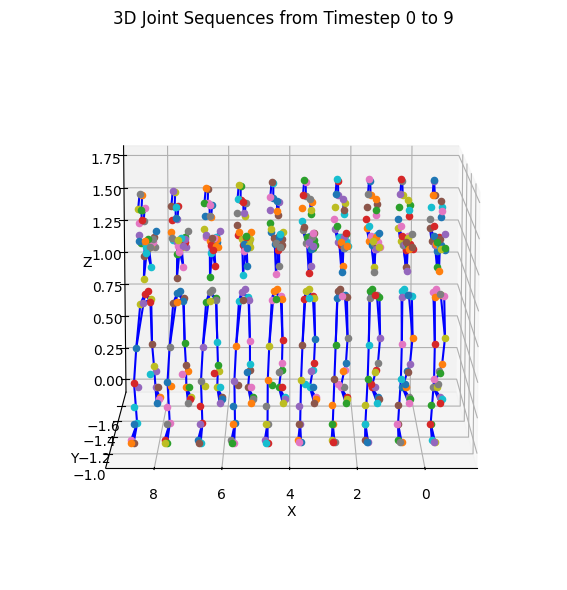

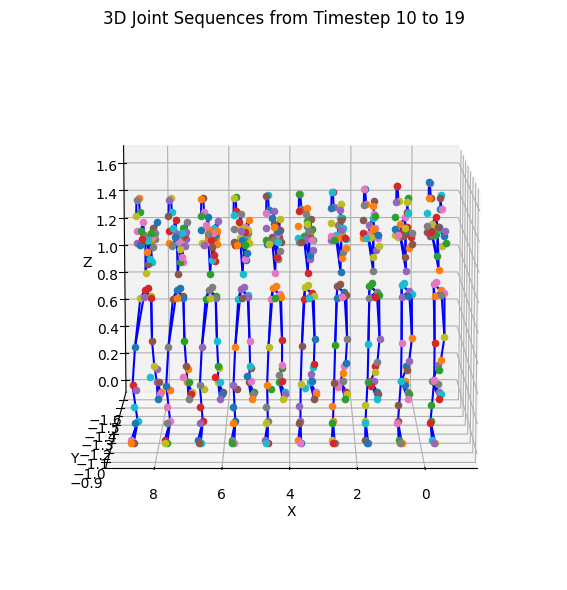

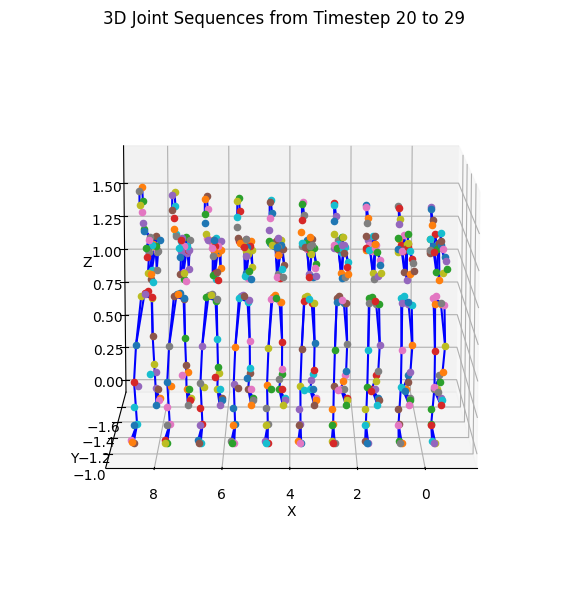

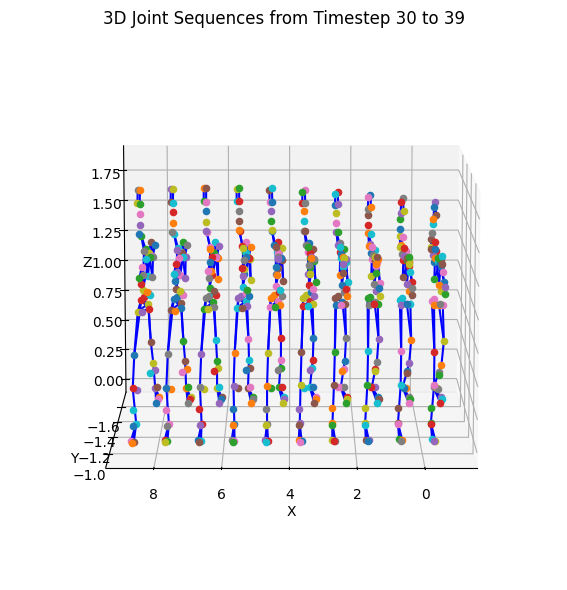

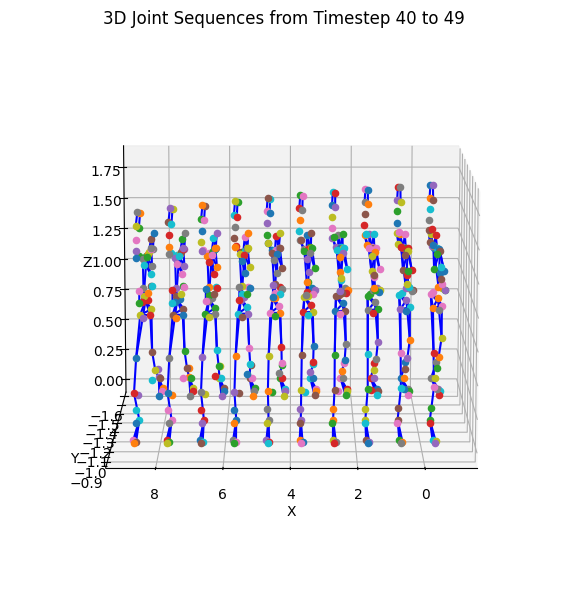

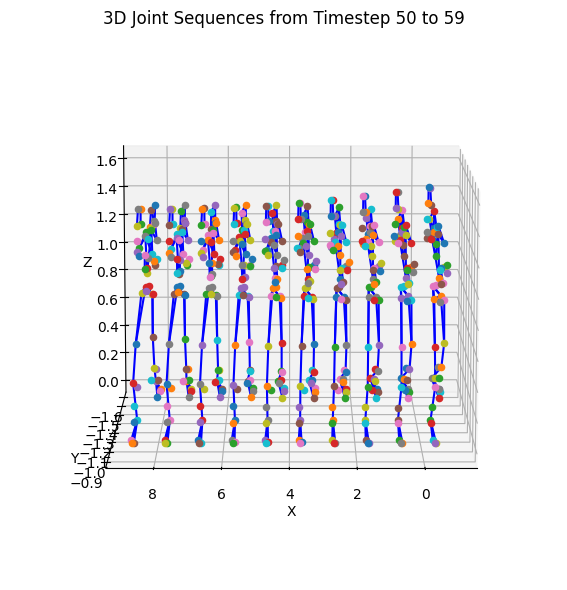

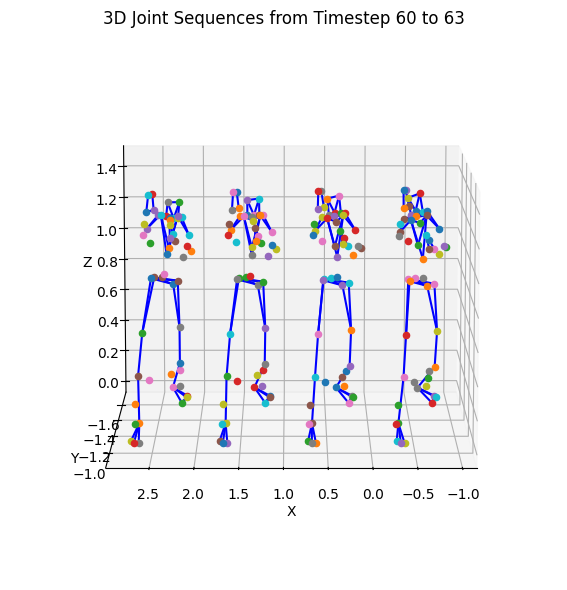

In [16]:
plot_sequence_sep(input, 10, joint_labels=point_labels, skeleton_lines=skeleton_lines)

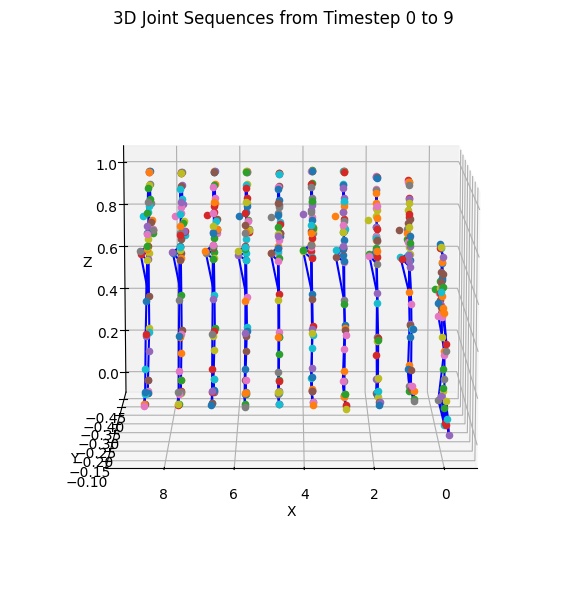

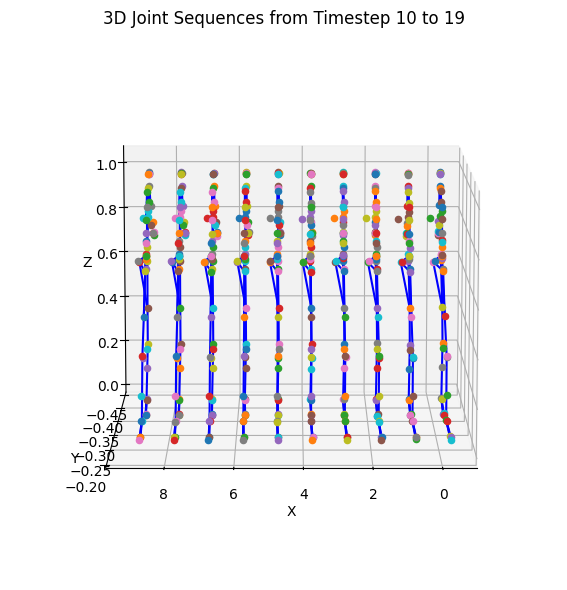

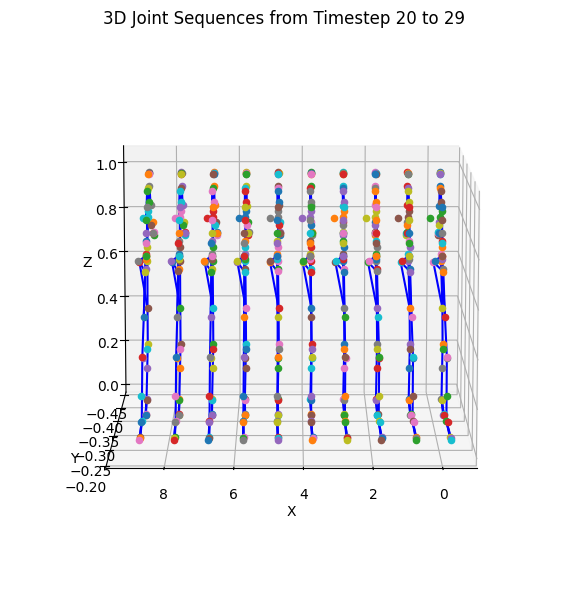

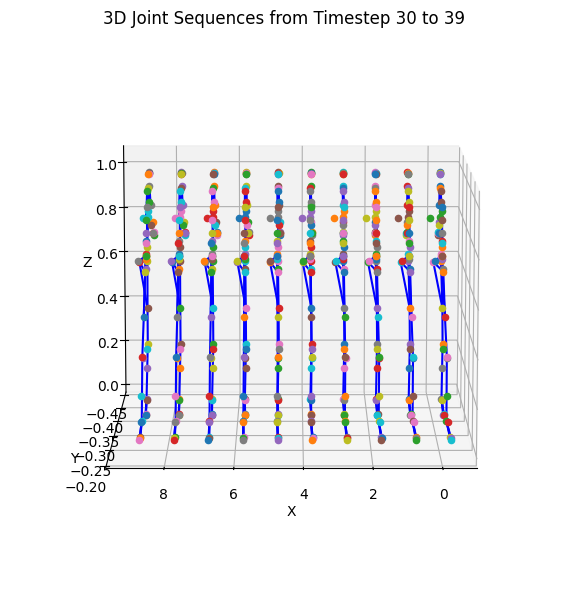

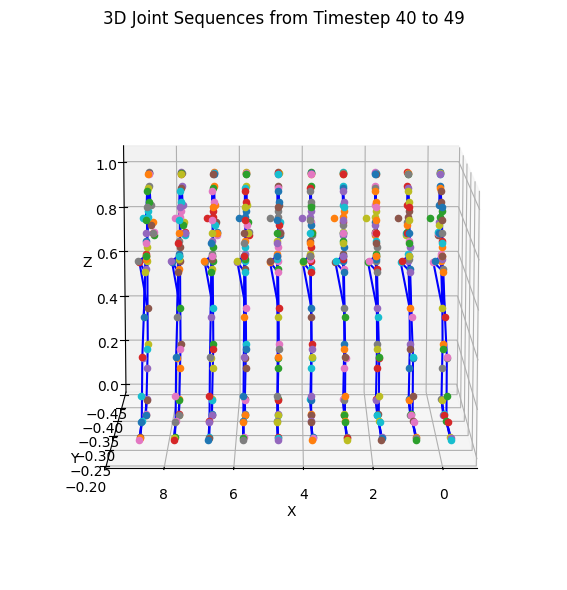

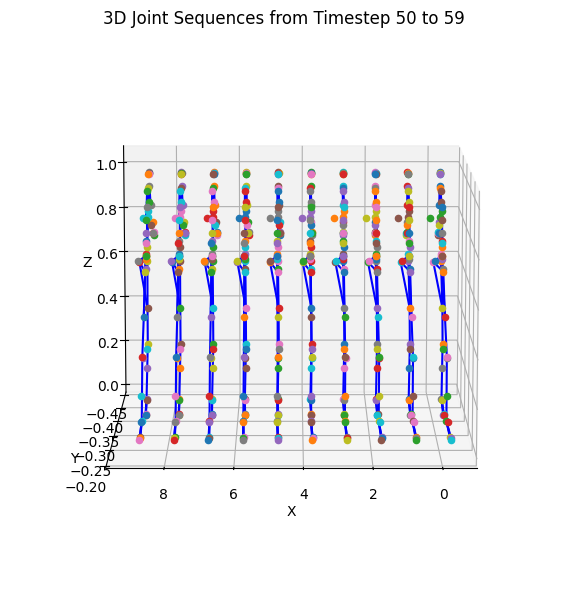

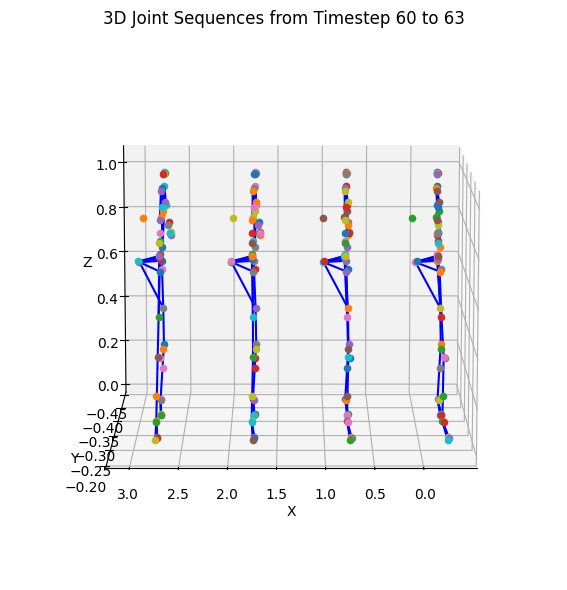

In [17]:
plot_sequence_sep(out, 10, skeleton_lines=skeleton_lines, joint_labels=point_labels)

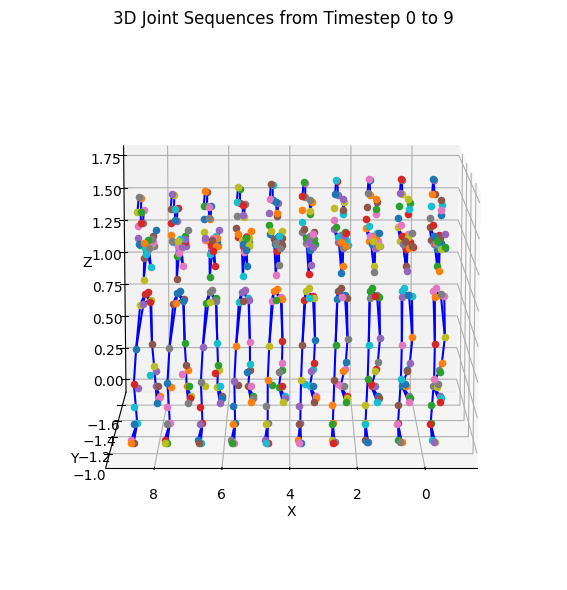

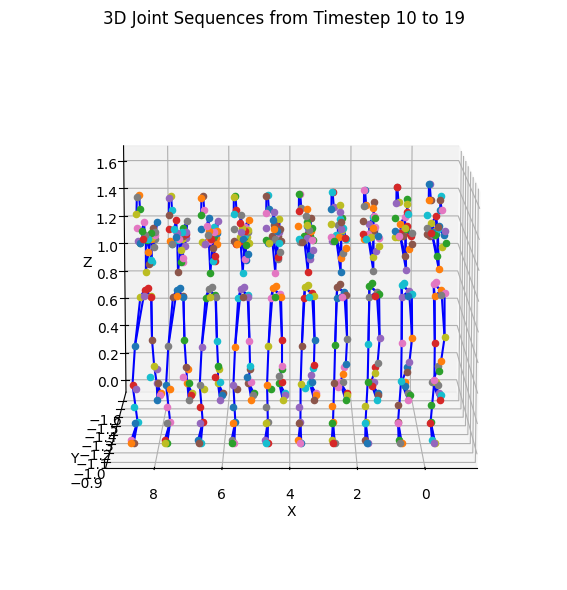

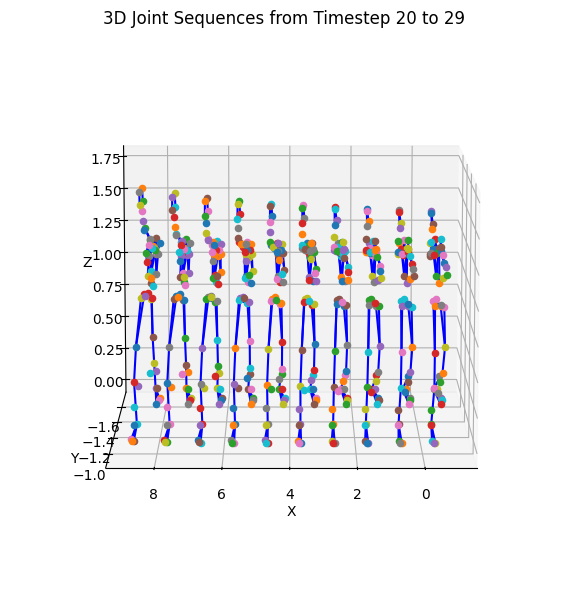

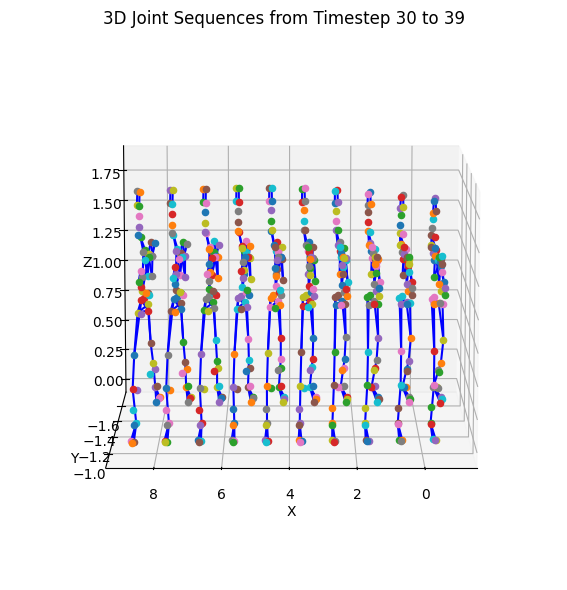

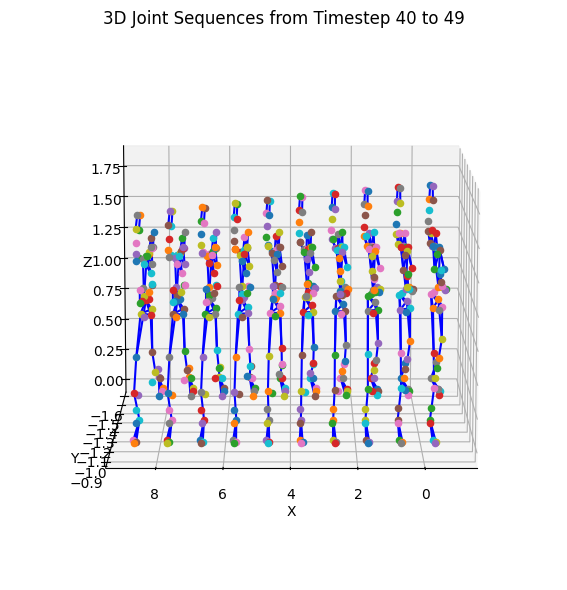

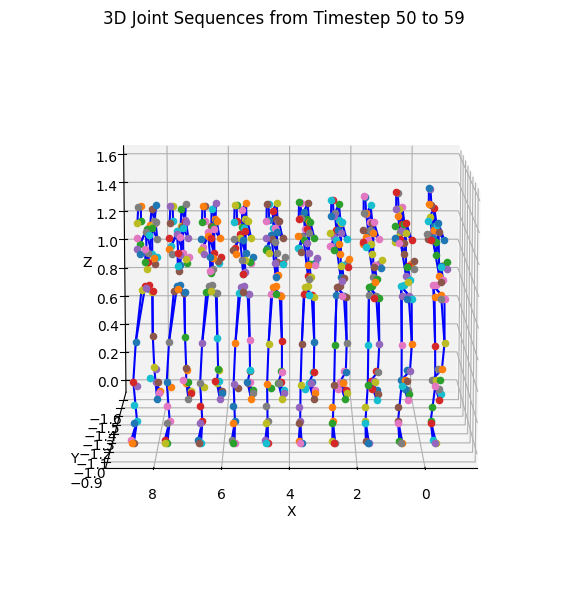

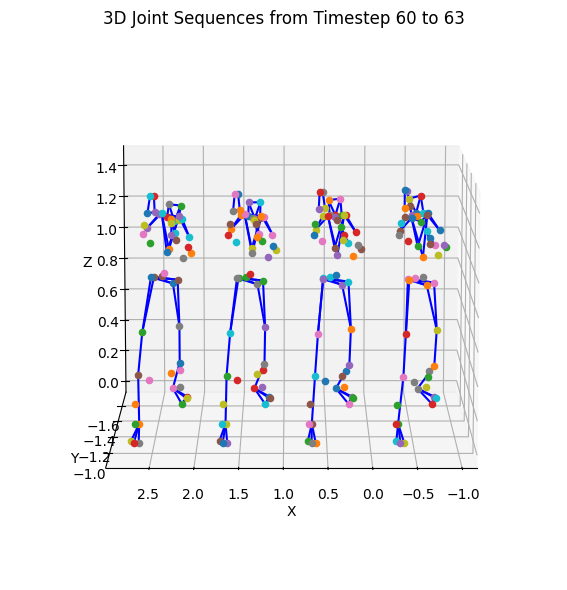

In [18]:
plot_sequence_sep(target, 10, step_size=1, skeleton_lines=skeleton_lines, joint_labels=point_labels)